# Git Storage Model

## Description
https://wiki/display/gqd/Git+Storage

gas_storage5

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys
path = os.getcwd()
while not path.endswith('research'):    
    path = os.path.abspath(os.path.join(path, '../'))
sys.path.append(path)

In [3]:
import os, sys
import pandas as pd
import numpy as np
from datetime import datetime, date

In [4]:
#a number of utilities:
from gmt.fom.gas.shared.utils.common import pa
from gmt.fom.gas.shared.utils.dframe import ddff
from gmt.fom.gas.shared.utils.common import flatten_lst

In [5]:
from gmt.fom.gas.shared.models.git_storage.git_storage import GitStorageModel

In [6]:
import cmdty_storage

In [7]:
sys.path.append(r'C:\git\storage-master\samples\python')

In [8]:
import logging

In [9]:
logger = logging.getLogger()

In [10]:
logger.setLevel(logging.INFO)

In [11]:
import storage_gui as sg

sg.display_gui()

# Market

## Forward

In [12]:
from gmt.fom.gas.shared.models.git_storage.data.fwd import Forward

In [13]:
forward = Forward(True,True,0.999)

In [14]:
forward.params

{'smooth_curve': True,
 'apply_weekend_shaping': True,
 'weekend_shaping_factor': 0.999}

In [15]:
forward.curve.plot()

<AxesSubplot:>

In [16]:
forward.curve

2021-01-20    18.440949
2021-01-21    18.456697
2021-01-22    18.472437
2021-01-23    18.469662
2021-01-24    18.485310
                ...    
2022-04-26    17.095956
2022-04-27    17.070184
2022-04-28    17.044411
2022-04-29    17.018637
2022-04-30    16.975871
Freq: D, Length: 466, dtype: float64

## IR

In [17]:
from gmt.fom.gas.shared.models.git_storage.data.ir import IR

In [18]:
ir = IR()

In [19]:
ir.curve

2021-04-25    0.005000
2021-04-26    0.005027
2021-04-27    0.005054
2021-04-28    0.005081
2021-04-29    0.005108
                ...   
2023-11-27    0.012588
2023-11-28    0.012591
2023-11-29    0.012594
2023-11-30    0.012597
2023-12-01    0.012600
Freq: D, Length: 951, dtype: float64

# Storage

In [20]:
from gmt.fom.gas.shared.models.git_storage.data.storage import Storage

In [21]:
storage = Storage('SIMPLE', 
                  storage_start='2021-04-01',
                  storage_end='2022-04-01',
                  injection_cost=0.01,
                  withdrawal_cost=0.025,
#                   cmdty_consumed_inject=0.0,
#                   cmdty_consumed_withdraw=0.0,
#                   inj_consumed_pctg=0.0,
#                   with_consumes_pctg=0.0,
                  #Specific to SIMPLE type:
                  min_inventory=0.0,
                  max_inventory=1500.0,
                  max_injection_rate=25.5,
                  max_withdrawal_rate=30.9)

In [22]:
storage.storage_type

<StorageType.SIMPLE: 'SIMPLE'>

In [23]:
storage.params

{'storage_start': '2021-04-01',
 'storage_end': '2022-04-01',
 'injection_cost': 0.01,
 'withdrawal_cost': 0.025,
 'cmdty_consumed_inject': 0.0,
 'cmdty_consumed_withdraw': 0.0,
 'storage_type': <StorageType.SIMPLE: 'SIMPLE'>,
 'min_inventory': 0.0,
 'max_inventory': 1500.0,
 'max_injection_rate': 25.5,
 'max_withdrawal_rate': 30.9}

In [24]:
from cmdty_storage import CmdtyStorage, RatchetInterp

In [25]:
storage_simple = CmdtyStorage(
    freq='D',
    storage_start = storage.storage_start,
    storage_end = storage.storage_end,
    injection_cost = storage.injection_cost,
    withdrawal_cost = storage.withdrawal_cost,
    min_inventory = storage.min_inventory,
    max_inventory = storage.max_inventory,
    max_injection_rate = storage.max_injection_rate,
    max_withdrawal_rate = storage.max_withdrawal_rate
)

# Calibrator

In [26]:
from gmt.fom.gas.shared.models.git_storage.calibrator import Calibrator

In [40]:
calibrator = Calibrator(spot_mean_reversion=30.0,
                        spot_vol=0.51,
                        long_term_vol=0.31,
                        seasonal_vol=0.2,
                        num_sims=4000,
                        basis_funcs= '1 + x_st + x_sw + x_lt + s + x_st**2 + x_sw**2 + x_lt**2 + s**2 + s * x_st',
                        seed=11,
                        seed_is_random=False,
                        fwd_sim_seed=13,
                        set_fwd_sim_seed=True,
                        extra_decisions=0,
                        num_inventory_grid_points=100,
                        numerical_tolerance=1e-10)

In [41]:
calibrator.params

{'spot_mean_reversion': 30.0,
 'spot_vol': 0.51,
 'long_term_vol': 0.31,
 'seasonal_vol': 0.2,
 'num_sims': 4000,
 'basis_funcs': '1 + x_st + x_sw + x_lt + s + x_st**2 + x_sw**2 + x_lt**2 + s**2 + s * x_st',
 'seed': 11,
 'seed_is_random': False,
 'fwd_sim_seed': 13,
 'set_fwd_sim_seed': True,
 'extra_decisions': 0,
 'num_inventory_grid_points': 100,
 'numerical_tolerance': 1e-10}

# Model

In [42]:
from gmt.fom.gas.shared.models.git_storage.git_storage import GitStorageModel

In [43]:
myModel = GitStorageModel(val_date='2021-04-25',
                          inventory=1500.0,
                          discount_deltas=False,
                          ir = ir,
                          forward=forward,
                          storage=storage, 
                          calibrator=calibrator
                          )
myModel.fit()
myModel.report()

2021-05-18 10:28:29,538: C:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\git_storage\git_storage.py: 84: INFO: Fitting....
2021-05-18 10:28:29,541: C:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\git_storage\git_storage.py: 89: INFO: Generating report.....


# Plug into Jake's model

In [31]:
from cmdty_storage import CmdtyStorage, three_factor_seasonal_value, MultiFactorModel, multi_factor, RatchetInterp

In [32]:
myModel.params

{'val_date': '2021-04-25', 'inventory': 1500.0, 'discount_deltas': False}

In [33]:
def settlement_rule(delivery_date):
    return delivery_date.asfreq('M').asfreq('D', 'end') + 20

In [36]:
myModel.calibrator.basis_funcs =  '1 + x_st + x_sw + x_lt + s + x_st**2 + x_sw**2 + x_lt**2 + s**2 + s * x_st'

In [38]:
# Call the three-factor seasonal model
three_factor_results = three_factor_seasonal_value(
    cmdty_storage = storage_simple,
    val_date = myModel.val_date,
    inventory = myModel.inventory,
    fwd_curve = myModel.forward.curve,
    interest_rates = myModel.ir.curve,
    settlement_rule = settlement_rule,
    num_sims = myModel.calibrator.num_sims,
    seed = myModel.calibrator.seed,
    spot_mean_reversion = myModel.calibrator.spot_mean_reversion,
    spot_vol = myModel.calibrator.spot_vol,
    long_term_vol =  myModel.calibrator.long_term_vol,
    seasonal_vol = myModel.calibrator.seasonal_vol,
    basis_funcs  = myModel.calibrator.basis_funcs, #'1 + x_st + x_sw + x_lt + s + x_st**2 + x_sw**2 + x_lt**2 + s**2 + s * x_st',
    discount_deltas = True
)

2021-05-18 10:10:34,637: cmdty.storage.multi-factor: 400: INFO: Compiling basis functions. Takes a few seconds on the first run..
2021-05-18 10:10:43,593: cmdty.storage.multi-factor: 402: INFO: Compilation of basis functions complete..
2021-05-18 10:10:43,596: cmdty.storage.multi-factor: 405: INFO: Calculating intrinsic value..
2021-05-18 10:10:44,267: cmdty.storage.multi-factor: 410: INFO: Calculation of intrinsic value complete..
2021-05-18 10:10:44,271: cmdty.storage.multi-factor: 413: INFO: Calculating LSMC value..
2021-05-18 10:10:44,395: cmdty.storage.multi-factor: 325: INFO: Starting regression spot price simulation..
2021-05-18 10:10:44,878: cmdty.storage.multi-factor: 325: INFO: Spot regression price simulation complete..
2021-05-18 10:10:44,893: cmdty.storage.multi-factor: 325: INFO: Starting backward induction..
2021-05-18 10:11:14,896: cmdty.storage.multi-factor: 325: INFO: Completed backward induction..
2021-05-18 10:11:14,900: cmdty.storage.multi-factor: 325: INFO: Starti

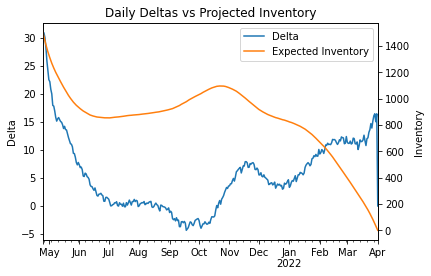

In [39]:
%matplotlib inline
ax_deltas = three_factor_results.deltas.plot(title='Daily Deltas vs Projected Inventory', legend=True, label='Delta')
ax_deltas.set_ylabel('Delta')
inventory_projection = three_factor_results.expected_profile['inventory']
ax_inventory = inventory_projection.plot(secondary_y=True, legend=True, ax=ax_deltas, label='Expected Inventory')
h1, l1 = ax_deltas.get_legend_handles_labels()
h2, l2 = ax_inventory.get_legend_handles_labels()
ax_inventory.set_ylabel('Inventory')
ax_deltas.legend(h1+h2, l1+l2, loc=1)

In [ ]:
myModel.calibrator.basis_funcs

## Let's try to compute

In [ ]:
myModel.forward.curve

In [ ]:
from cmdty_storage import CmdtyStorage, three_factor_seasonal_value, MultiFactorModel, multi_factor, RatchetInterp

In [ ]:
myModel.storage.storage_type.value

In [ ]:
fwd_curve = myModel.forward.curve

In [ ]:
storage = CmdtyStorage(freq='D',
                      storage_start=myModel.storage.storage_start,
                      storage_end=myModel.storage.storage_end,
                      injection_cost=myModel.storage.injection_cost,
                      withdrawal_cost=myModel.storage.withdrawal_cost,
                      min_inventory=myModel.storage.min_inventory,
                      max_inventory=myModel.storage.max_inventory,
                      max_injection_rate=myModel.storage.max_injection_rate,
                      max_withdrawal_rate=myModel.storage.max_withdrawal_rate,
                      cmdty_consumed_inject=myModel.storage.cmdty_consumed_inject,
                      cmdty_consumed_withdraw=myModel.storage.cmdty_consumed_withdraw)

In [ ]:
myModel.ir.curve

In [ ]:
def twentieth_of_next_month(period): return period.asfreq('M').asfreq('D', 'end') + 20

In [ ]:
pd.Period(myModel.storage.storage_end, freq='D')

In [ ]:
twentieth_of_next_month(pd.Period(myModel.storage.storage_end, freq='D'))

In [ ]:
myModel.storage.storage_end

In [ ]:
interest_rate_curve = pd.Series(index=pd.period_range(myModel.asof,
twentieth_of_next_month(
pd.Period(myModel.storage.storage_end, freq='D')), freq='D'),
dtype='float64')

In [ ]:
interest_rate_curve[:] = myModel.ir.curve

In [ ]:
interest_rate_curve

In [ ]:
seed = None if myModel.calibrator.seed_is_random else myModel.calibrator.seed

In [ ]:
fwd_sim_seed = myModel.calibrator.fwd_sim_seed if myModel.calibrator.fwd_sim_seed else None

In [ ]:
import gmt.fom.gas.shared.config

In [ ]:
import logging

In [ ]:
logger = logging.getLogger()

In [ ]:
def on_progress(progress):
    logger.info(progress)
    

In [ ]:
val_results_3f = three_factor_seasonal_value(
    cmdty_storage = storage,
    val_date = myModel.asof,
    inventory=myModel.inventory,
    fwd_curve=fwd_curve,
    interest_rates=interest_rate_curve,
    settlement_rule=twentieth_of_next_month,
    spot_mean_reversion=myModel.calibrator.spot_mean_reversion,
    spot_vol=myModel.calibrator.spot_vol,
    long_term_vol=myModel.calibrator.long_term_vol,
    seasonal_vol=myModel.calibrator.seasonal_vol,
    num_sims=myModel.calibrator.num_sims,
    basis_funcs=myModel.calibrator.basis_funcs,
    discount_deltas=myModel.discount_deltas,
    seed=seed,
    fwd_sim_seed=fwd_sim_seed,
    extra_decisions=myModel.calibrator.extra_decisions,
    num_inventory_grid_points=myModel.calibrator.num_inventory_grid_points,
    on_progress_update=on_progress,
    numerical_tolerance=myModel.calibrator.numerical_tolerance
)

In [ ]:
params_dict = dict(cmdty_storage = storage,
    val_date = myModel.asof,
    inventory=myModel.inventory,
    fwd_curve=fwd_curve,
    interest_rates=interest_rate_curve,
    settlement_rule=twentieth_of_next_month,
    spot_mean_reversion=myModel.calibrator.spot_mean_reversion,
    spot_vol=myModel.calibrator.spot_vol,
    long_term_vol=myModel.calibrator.long_term_vol,
    seasonal_vol=myModel.calibrator.seasonal_vol,
    num_sims=myModel.calibrator.num_sims,
    basis_funcs=myModel.calibrator.basis_funcs,
    discount_deltas=myModel.discount_deltas,
    seed=seed,
    fwd_sim_seed=fwd_sim_seed,
    extra_decisions=myModel.calibrator.extra_decisions,
    num_inventory_grid_points=myModel.calibrator.num_inventory_grid_points,
    on_progress_update=on_progress,
    numerical_tolerance=myModel.calibrator.numerical_tolerance)

In [ ]:
storage

In [ ]:
params_dict['settlement_rule']

In [ ]:
b = 5

gui.on_load_val_data_clicked(b)

gui.on_load_curve_params(b)

gui.on_import_fwd_curve_clicked(b)

gui.on_load_storage_details_clicked(b)

gui.on_load_vol_params_clicked(b)

gui.on_load_tech_params(b)

res = gui.btn_clicked(b)

# res_tpl = stb.utils.common.to_namedtuple(res, True)